# Backtest Demo with `TaoTrader`

In [1]:
# ✅ 初始化导入
from data.market_data import OKXDataFetcher
from core.context import BacktestContext
from core.strategy_registry import StrategyRegistry
from backtest.backtest_engine import BacktestEngine
from backtest.performance_metrics import analyze_performance
from execution.trade_logger import TradeLogger
from risk_management.risk_checker import RiskChecker
from utils.plots import ChartPlotter
from backtest.reporter import generate_markdown_report
from core.strategy_loader import load_all_strategies
from indicators.all_indicators import calculate_volume_heatmap
from indicators.support_resistance import SupportResistancePivotIndicator
from indicators.ema import EMAIndicator
from indicators.vol_heatmap import VolumeHeatmapIndicator
from IPython.display import display, Markdown

load_all_strategies()

In [2]:
# 加载配置与数据
ctx = BacktestContext(
    strategy_config_path='configs/strategy/ma_crossover.yaml',
    backtest_config_path='configs/backtest.yaml',
    risk_config_path='configs/risk.yaml'
)

fetcher = OKXDataFetcher()
df = fetcher.get_kline('BTC-USDT-SWAP', bar='4H', total=1500)
df

[2025-06-12 22:06:08] INFO - HTTP Request: GET https://www.okx.com/api/v5/market/candles?instId=BTC-USDT-SWAP&bar=4H&limit=300 "HTTP/2 200 OK"
[2025-06-12 22:06:09] INFO - HTTP Request: GET https://www.okx.com/api/v5/market/candles?instId=BTC-USDT-SWAP&after=1745467200000&bar=4H&limit=300 "HTTP/2 200 OK"
[2025-06-12 22:06:09] INFO - HTTP Request: GET https://www.okx.com/api/v5/market/candles?instId=BTC-USDT-SWAP&after=1741147200000&bar=4H&limit=300 "HTTP/2 200 OK"
[2025-06-12 22:06:10] INFO - HTTP Request: GET https://www.okx.com/api/v5/market/candles?instId=BTC-USDT-SWAP&after=1736827200000&bar=4H&limit=300 "HTTP/2 200 OK"
[2025-06-12 22:06:10] INFO - HTTP Request: GET https://www.okx.com/api/v5/market/candles?instId=BTC-USDT-SWAP&after=1732507200000&bar=4H&limit=300 "HTTP/2 200 OK"
[2025-06-12 22:06:10] INFO - HTTP Request: GET https://www.okx.com/api/v5/market/candles?instId=BTC-USDT-SWAP&after=1729051200000&bar=4H&limit=60 "HTTP/2 200 OK"


,open,high,low,close,volume
timestamp,,,,,
2024-10-16 04:00:00,67103.2,67361.3,66760.4,66972.9,1114334.60
2024-10-16 08:00:00,66973.0,68432.5,66912.2,67908.7,3329024.40
2024-10-16 12:00:00,67908.7,68329.0,67132.0,67763.3,4195648.50
2024-10-16 16:00:00,67763.3,68111.0,67488.0,67727.2,1285057.50
2024-10-16 20:00:00,67727.1,67972.9,67504.0,67621.8,694817.60
...,...,...,...,...,...
2025-06-12 08:00:00,107577.6,107796.4,106823.0,106868.2,1023356.61
2025-06-12 12:00:00,106868.2,107755.4,106533.0,106960.0,2119307.20
2025-06-12 16:00:00,106960.0,108395.0,106628.0,106753.5,1937096.69


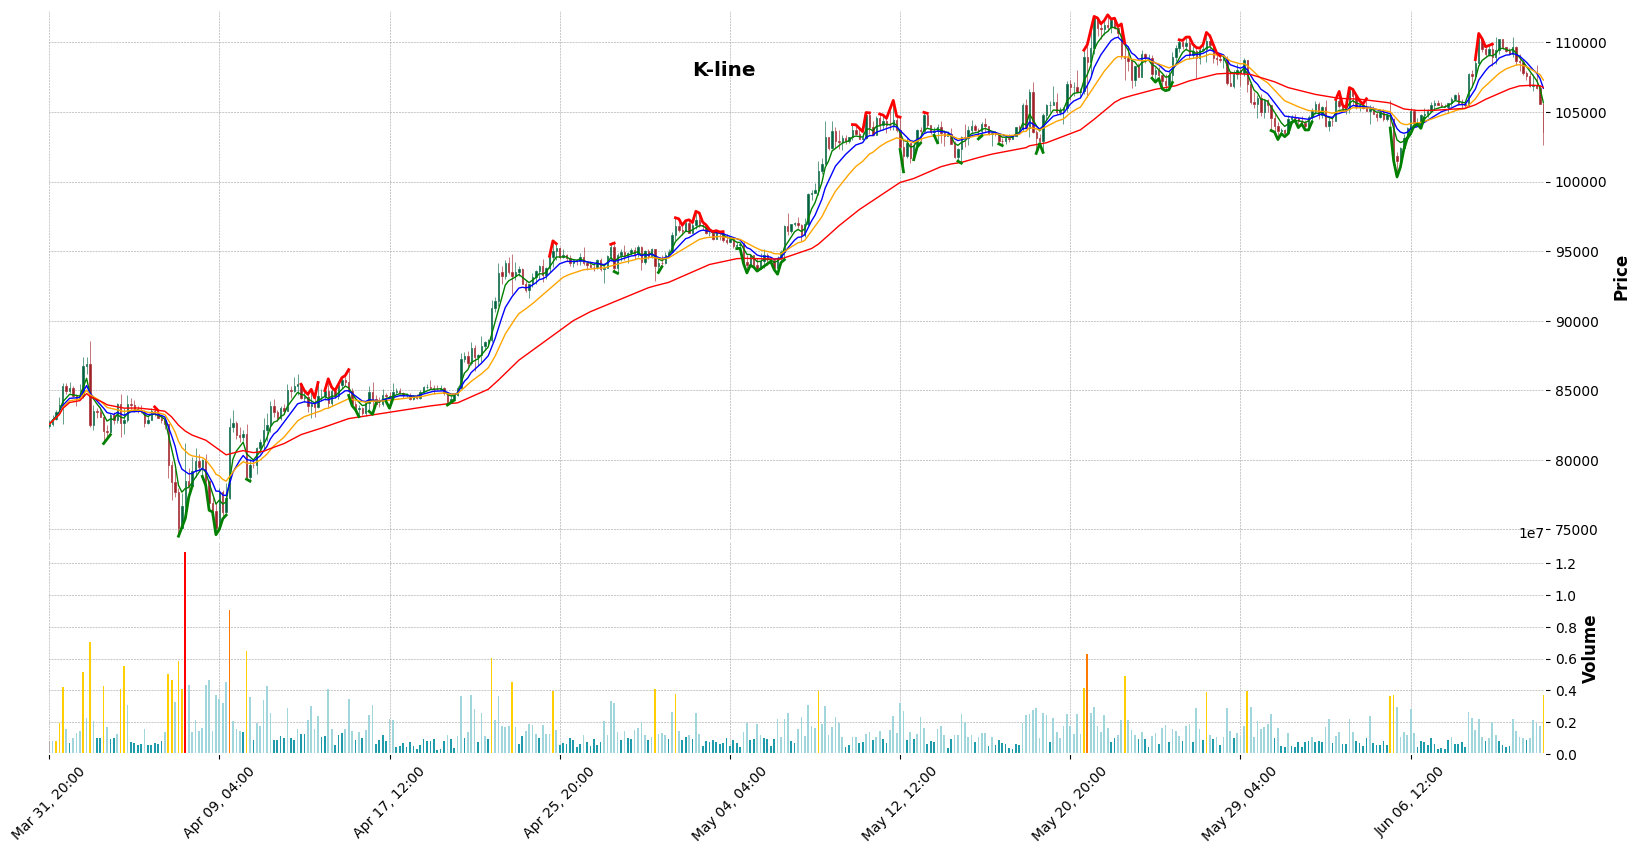

In [4]:
plotter = ChartPlotter([
    EMAIndicator(spans=[5, 10, 20, 60]),
    VolumeHeatmapIndicator(),
    SupportResistancePivotIndicator()
])
plotter.plot(df[1000:])

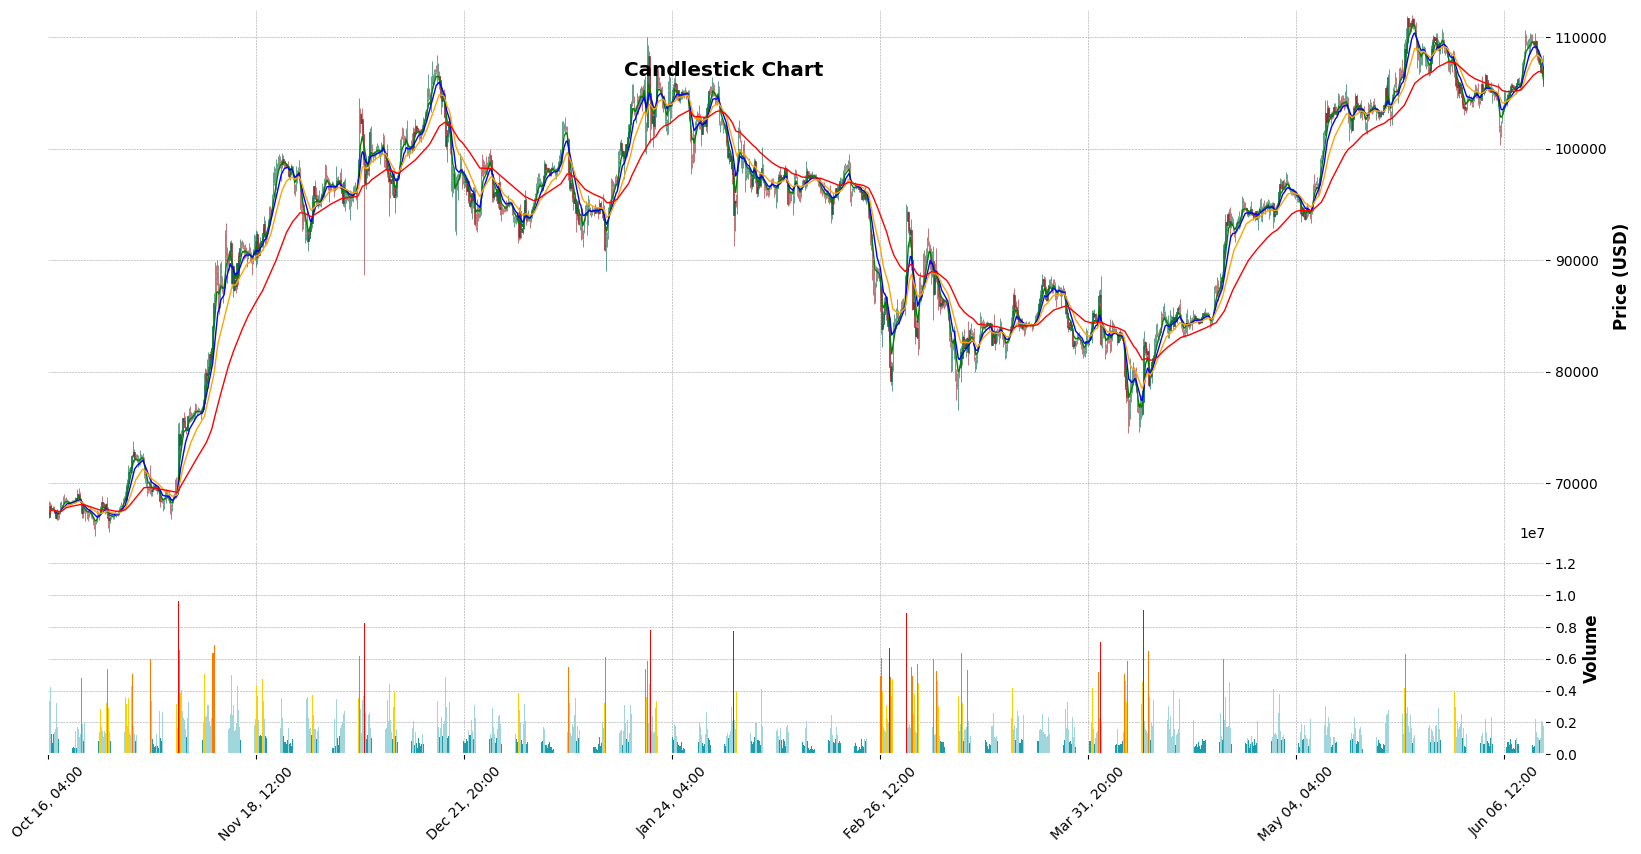

In [3]:
df_heatmap = calculate_volume_heatmap(df)

# 然后这样调用即可
plot_kline_chart(df_heatmap)

In [4]:
print(df_heatmap.columns)

Index(['open', 'high', 'low', 'close', 'volume', 'vol_ma', 'vol_std', 'stdbar',
       'volume_category', 'volume_rank'],
      dtype='object')


In [5]:
indicator = SupportResistanceIndicator(window=50, tolerance=0.005, min_tests=3, min_volume_rank=2)
zones_df = indicator.identify_zones(df_heatmap)
display(zones_df)

KeyError: 'price'

In [ ]:
#初始化策略与组件
strategy_cls = StrategyRegistry.get("MA_Crossover")
trade_logger = TradeLogger()
risk_checker = RiskChecker(ctx)

engine = BacktestEngine(
    strategy_class=strategy_cls,
    data=df,
    context=ctx,
    trade_logger=trade_logger,
    risk_checker=risk_checker
)
engine.run()
unrealized = engine.get_unrealized()

In [ ]:
# 📊 回测结果分析
trades_df = trade_logger.to_dataframe()
perf = analyze_performance(trades_df, unrealized=unrealized)

def show_perf(perf):
    md = "\n".join([f"- **{k}**: {v}" for k, v in perf.items()])
    display(Markdown("##Performance Summary\n" + md))

show_perf(perf)
trades_df.tail()

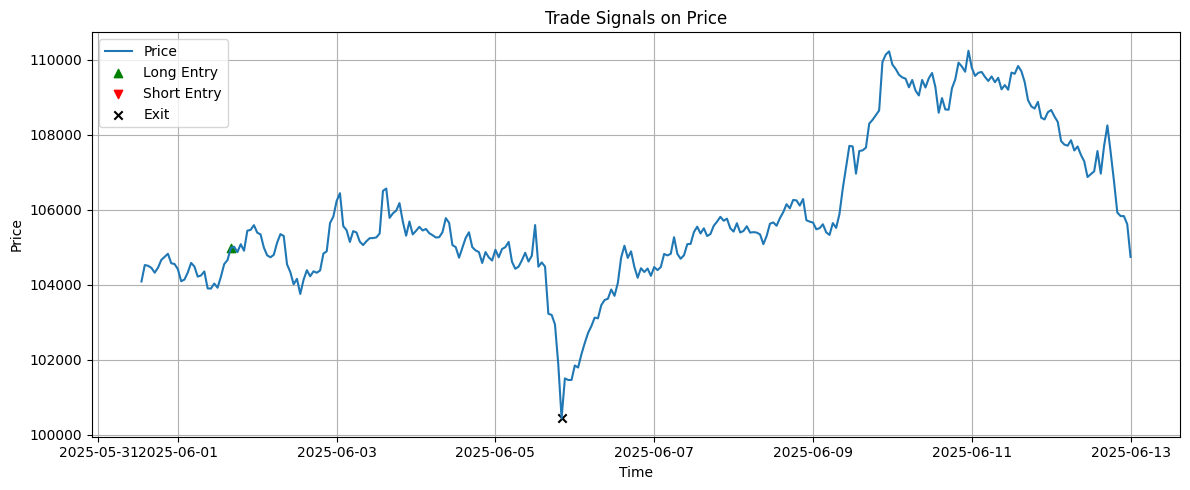

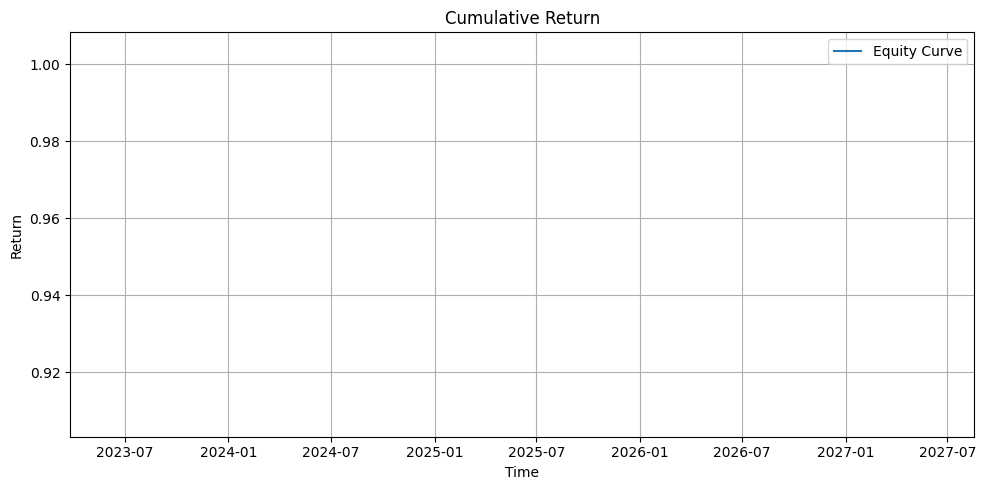

In [5]:
# 可视化买卖点与PnL曲线
plot_signals_on_price(df, trades_df)
plot_pnl_curve(trades_df)

In [6]:
# 导出Markdown报告
filepath = generate_markdown_report(trades_df, perf, unrealized)

def show_markdown_report(path):
    if not path:
        print("No report file to display.")
        return
    try:
        with open(path, 'r', encoding='utf-8') as f:
            content = f.read()
        display(Markdown(content))
    except Exception as e:
        print(f"Failed to load report: {e}")
    
show_markdown_report(filepath)

[2025-06-12 20:05:00] INFO - Markdown report saved to: reports\backtest_report_20250612.md


# Backtest Summary Report

## Performance Overview

- **Total Trades**: 1
- **Total PnL ($)**: -3710.94
- **Average PnL ($)**: -3710.94
- **Unrealized Position**: {'entry_time': Timestamp('2025-06-06 07:00:00'), 'entry_price': np.float64(103102.1), 'current_price': np.float64(104738.6), 'qty': np.float64(0.4635147368729146), 'capital': np.float64(47789.34275254493), 'direction': 'long', 'pnl_dollar': np.float64(710.3732532065336), 'pnl_pct': np.float64(0.014864679283933112)}

## Trades Overview

Total Trades: 1

| Entry Time | Exit Time | Direction | Entry Price | Exit Price | Qty | Capital | PnL (%) | PnL ($) | Reason |
|------------|-----------|-----------|--------------|-------------|-----|----------|----------|---------|--------|
| 2025-06-01 16:00:00 | 2025-06-05 20:00:00 | long | 104973.40 | 100434.90 | 0.9526 | 100000.00 | -4.42% | -4421.31 | stop_loss |

## Unrealized Position at End

- **Entry Time**: 2025-06-06 07:00:00
- **Entry Price**: 103102.10
- **Qty**: 0.4635
- **Capital**: 47789.34
- **Current Price**: 104738.60
- **Direction**: long
- **Unrealized PnL (%)**: 1.49%
- **Unrealized PnL ($)**: 710.37

---
Report generated at 2025-06-12 20:05:00.088238


In [1]:
from data.market_data import BinanceDataFetcher
fetcher = BinanceDataFetcher()

# 获取最近100根1小时K线
df = fetcher.get_kline(symbol="ETHUSDT", interval="1h", limit=100)
print(df.tail())

# 分页获取过去1000根K线（超出API限制的批量）
df_long = fetcher.get_kline_paged(symbol="BTCUSDT", interval="15m", total=1000)
print(df_long.tail())

# 获取全市场USDT ticker排行
df_ticker = fetcher.get_all_tickers()
print(df_ticker.head())

                        open     high      low    close      volume
timestamp                                                          
2025-06-16 21:00:00  2669.79  2671.57  2645.00  2648.97  17632.8976
2025-06-16 22:00:00  2648.97  2657.68  2544.21  2570.30  84507.0983
2025-06-16 23:00:00  2570.29  2596.39  2535.00  2544.17  60987.8437
2025-06-17 00:00:00  2544.17  2588.60  2524.54  2587.70  58690.0630
2025-06-17 01:00:00  2587.70  2592.34  2580.11  2584.80   3060.1799
                          open       high        low      close     volume
timestamp                                                                 
2025-06-17 00:00:00  106794.53  106828.75  106147.55  106231.89  712.61513
2025-06-17 00:15:00  106231.90  106926.62  106115.35  106801.30  400.37330
2025-06-17 00:30:00  106801.29  106993.78  106655.98  106739.99  168.95605
2025-06-17 00:45:00  106740.00  107262.31  106740.00  107238.63  196.97500
2025-06-17 01:00:00  107238.68  107310.74  107148.01  107204.46   49.40898

D:\Projects\PythonProjects\TaoTrader\data\market_data.py:137: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors='ignore')


In [2]:
df_ticker

,symbol,priceChange,priceChangePercent,weightedAvgPrice,prevClosePrice,lastPrice,lastQty,bidPrice,bidQty,askPrice,...,highPrice,lowPrice,volume,quoteVolume,openTime,closeTime,firstId,lastId,count,volume_usd_million
12,ETHUSDT,40.3000,1.584,2604.859646,2544.49000,2584.8000,3.35350,2584.7900,2.406600e+00,2584.8000,...,2680.3400,2514.8500,7.271184e+05,1.894041e+09,1750035919013,1750122319013,2535023271,2538699094,3675824,1894.041289
11,BTCUSDT,1769.2900,1.678,107200.534271,105435.16000,107204.4600,0.00856,107204.4500,4.831860e+00,107204.4600,...,108952.3800,104980.3700,1.600701e+04,1.715960e+09,1750035919013,1750122319013,5013993232,5017144687,3151456,1715.959814
422,USDCUSDT,-0.0002,-0.020,0.999671,0.99980,0.9996,296.00000,0.9995,3.457726e+07,0.9996,...,0.9999,0.9994,1.458446e+09,1.457966e+09,1750035919414,1750122319414,281593272,281928564,335293,1457.966009
779,SOLUSDT,-0.1700,-0.112,155.077857,152.04000,151.8800,0.28000,151.8800,2.431910e+02,151.8900,...,158.8000,147.4700,3.898803e+06,6.046180e+08,1750035919793,1750122319793,1340532502,1342943554,2411053,604.618047
306,XRPUSDT,0.0842,3.893,2.261316,2.16310,2.2473,962.10000,2.2472,3.297400e+03,2.2473,...,2.3370,2.1512,1.965468e+08,4.444545e+08,1750035919306,1750122319306,1184850585,1186530192,1679608,444.454477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,USDSBUSDT,0.0000,0.000,0.000000,0.00000,0.0000,0.00000,0.0000,0.000000e+00,0.0000,...,0.0000,0.0000,0.000000e+00,0.000000e+00,1749111997641,1749198397641,-1,-1,0,0.000000
547,GTOUSDT,0.0000,0.000,0.000000,0.01233,0.0000,0.00000,0.0000,0.000000e+00,0.0000,...,0.0000,0.0000,0.000000e+00,0.000000e+00,1749111997641,1749198397641,-1,-1,0,0.000000
553,ERDUSDT,0.0000,0.000,0.000000,0.00000,0.0000,0.00000,0.0000,0.000000e+00,0.0000,...,0.0000,0.0000,0.000000e+00,0.000000e+00,1749111997641,1749198397641,-1,-1,0,0.000000
475,XMRUSDT,0.0000,0.000,0.000000,118.70000,0.0000,0.00000,0.0000,0.000000e+00,0.0000,...,0.0000,0.0000,0.000000e+00,0.000000e+00,1749111997641,1749198397641,-1,-1,0,0.000000


In [3]:
df_long

,open,high,low,close,volume
timestamp,,,,,
2025-06-06 15:15:00,105166.78,105333.00,104747.53,104827.11,377.25867
2025-06-06 15:30:00,104827.10,104956.00,104616.12,104696.57,266.04501
2025-06-06 15:45:00,104696.57,105111.00,104696.56,105092.28,211.58901
2025-06-06 16:00:00,105092.28,105130.16,104982.87,105007.93,195.03794
2025-06-06 16:15:00,105007.93,105284.00,104997.13,105071.41,395.46349
...,...,...,...,...,...
2025-06-17 00:00:00,106794.53,106828.75,106147.55,106231.89,712.61513
2025-06-17 00:15:00,106231.90,106926.62,106115.35,106801.30,400.37330
2025-06-17 00:30:00,106801.29,106993.78,106655.98,106739.99,168.95605
